# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, Any, Dict
from tqdm import tqdm

SEED = 123

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = '{device}'")


!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

df = pd.read_csv('data.txt.zip', header=None)
df

device = 'cuda'
--2022-10-10 08:30:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  42.3MB/s    in 5.2s    

2022-10-10 08:31:03 (38.6 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



0         1         2         3         4         5         6   \
0       2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905   
1       2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   
2       2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940   
3       2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   
4       2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409   
...      ...       ...       ...       ...       ...       ...       ...   
515340  2006  51.28467  45.88068  22.19582  -5.53319  -3.61835 -16.36914   
515341  2006  49.87870  37.93125  18.65987  -3.63581 -27.75665 -18.52988   
515342  2006  45.12852  12.65758 -38.72018   8.80882 -29.29985  -2.28706   
515343  2006  44.16614  32.38368  -3.34971  -2.49165 -19.59278 -18.67098   
515344  2005  51.85726  59.11655  26.39436  -5.46030 -20.69012 -19.95528   

              7         8         9   ...        81         82         83  \
0      -25.01202 -12.23257   7.83089  ...  13.01620  -54.40548   58.99367   
1        8.76630  -0.92019  18.76548  ...   5.66812  -19.68073   33.04964   
2       -3.27872  -2.35035  16.07017  ...   3.03800   26.05866  -50.92779   
3        5.05097 -10.34124   3.55005  ...  34.57337 -171.70734  -16.96705   
4      -12.48207  -9.37636  12.63699  ...   9.92661  -55.95724   64.92712   
...          ...       ...       ...  ...       ...        ...        ...   
515340   2.12652   5.18160  -8.66890  ...   4.81440   -3.75991  -30.92584   
515341   7.76108   3.56109  -2.50351  ...  32.38589  -32.75535  -61.05473   
515342 -18.40424 -22.28726  -4.52429  ... -18.73598  -71.15954 -123.98443   
515343   8.78428   4.02039 -12.01230  ...  67.16763  282.77624   -4.63677   
515344  -6.72771   2.29590  10.31018  ... -11.50511  -69.18291   60.58456   

               84        85        86         87        88         89  \
0        15.37344   1.11144 -23.08793   68.40795  -1.82223  -27.46348   
1        42.87836  -9.90378 -32.22788   70.49388  12.04941   58.43453   
2        10.93792  -0.07568  43.20130 -115.00698  -0.05859   39.67068   
3       -46.67617 -12.51516  82.58061  -72.08993   9.90558  199.62971   
4       -17.72522  -1.49237  -7.50035   51.76631   7.88713   55.66926   
...           ...       ...       ...        ...       ...        ...   
515340   26.33968  -5.03390  21.86037 -142.29410   3.42901  -41.14721   
515341   56.65182  15.29965  95.88193  -10.63242  12.96552   92.11633   
515342  121.26989  10.89629  34.62409 -248.61020  -6.07171   53.96319   
515343  144.00125  21.62652 -29.72432   71.47198  20.32240   14.83107   
515344   28.64599  -4.39620 -64.56491  -45.61012  -5.51512   32.35602   

              90  
0        2.26327  
1       26.92061  
2       -0.66345  
3       18.85382  
4       28.74903  
...          ...  
515340 -15.46052  
515341  10.88815  
515342  -8.09364  
515343  39.74909  
515344  12.17352  

[515345 rows x 91 columns]

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

---

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
print(X_train.shape)
X_train

(1000, 90)


array([[ 4.9943570e+01,  2.1471140e+01,  7.3077500e+01, ...,
        -1.8222300e+00, -2.7463480e+01,  2.2632700e+00],
       [ 4.8732150e+01,  1.8429300e+01,  7.0326790e+01, ...,
         1.2049410e+01,  5.8434530e+01,  2.6920610e+01],
       [ 5.0957140e+01,  3.1856020e+01,  5.5818510e+01, ...,
        -5.8590000e-02,  3.9670680e+01, -6.6345000e-01],
       ...,
       [ 4.3250670e+01,  1.8779470e+01,  6.1010040e+01, ...,
         2.6668000e+00,  1.5795616e+02, -1.3582500e+00],
       [ 3.9768240e+01, -3.0945570e+01,  6.3830700e+01, ...,
        -7.0317000e-01,  1.7778420e+01, -1.3100230e+01],
       [ 4.1877250e+01,  1.8103900e+00,  5.7802020e+01, ...,
        -4.9247900e+00, -1.7408060e+01, -1.0615610e+01]])

In [ ]:
print(y_train.shape)
y_train

(463715,)


array([2001, 2001, 2001, ..., 2007, 2006, 2007])

100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


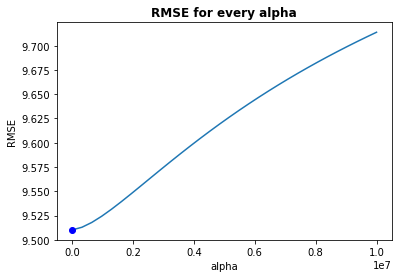

For Ridge(alpha=1e-63) RMSE = 9.51


In [ ]:
alphas = [value for value in np.linspace(10e-64, 10e6, 32)]
rates = []
for alpha in tqdm(alphas):
  model = Ridge(alpha=alpha)
  model.fit(X_train, y_train)
  rates.append(mean_squared_error(y_test, model.predict(X_test), squared=False))

best_alpha = alphas[np.argmin(rates)]

model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
ridge_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
  
plt.plot(alphas, rates)
plt.plot(best_alpha, ridge_rmse, 'bo')
plt.title("RMSE for every alpha", fontWeight="bold")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.show()

print("For Ridge(alpha=%2.e) RMSE = %.2f" % (best_alpha, ridge_rmse))

In [ ]:
y_const_predict = np.full_like(y_test, np.mean(y_train))
print("For *const* RMSE = %.2f" % (mean_squared_error(y_test, y_const_predict, squared=False)))

For *const* RMSE = 10.86


---

# Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(SEED)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
set_random_seed(SEED)

MEAN = np.mean(y_train)
STD = np.std(y_train)

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [ ]:
# set_random_seed(SEED)

# MIN = np.min(y_train)
# MAX = np.max(y_train)

# scaler = MinMaxScaler()

# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
# scaler = MinMaxScaler().fit(y_train)
# y_train = scaler.transform(y_train)
# y_test = scaler.transform(y_test)

In [ ]:
y_train

array([[0.23893634],
       [0.23893634],
       [0.23893634],
       ...,
       [0.78739469],
       [0.69598496],
       [0.78739469]])

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float, requires_grad=True, device=device)
X_test = torch.tensor(X_test, dtype=torch.float, requires_grad=True, device=device)
y_train = torch.tensor(y_train, dtype=torch.float, device=device)
y_test = torch.tensor(y_test, dtype=torch.float, device=device)

In [ ]:
f"{y_train.size()} {X_train.size()} \n {y_test.size()} {X_test.size()}"

'torch.Size([463715, 1]) torch.Size([463715, 90]) \n torch.Size([51630, 1]) torch.Size([51630, 90])'

In [ ]:
class MusicDataset(torch.utils.data.Dataset):
    """Dataset of music parameters"""
    def __init__(self, X: torch.Tensor, y: torch.Tensor) -> None:
      super().__init__()
      self.X :torch.Tensor = X
      self.y :torch.Tensor = y

    def __len__(self) -> int:
        return self.X.size()[0]

    def __getitem__(self, idx: int):
      return {'sample': self.X[idx, :], 'target': self.y[idx]}

In [ ]:
set_random_seed(SEED)

train_set = MusicDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)

test_set = MusicDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)

test_set_for_val_test = MusicDataset(X_test, y_test)
test_loader_for_val_test = torch.utils.data.DataLoader(test_set_for_val_test, batch_size=len(test_set_for_val_test))

set_random_seed(SEED)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
).to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0023, weight_decay=0.00005)

# lambda_func = lambda epoch: 0.9 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.7)


criterion = nn.MSELoss()

In [ ]:
from IPython.core.display import deepcopy

# Определим глобальные переменные
# Не очень хорошо, но не возвращать же полную конфигурацию модели, для сессий дообучения
val_res = []
rmse_s = []
batches = []
n_batch = 0
current_min = 10e8
best_model = model
current_mins = []

def train(n_epochs, model, optimizer, criterion, scheduler, train_loader, test_loader, graphics, scaler, early_stopping, new_session, old_data: tuple = None):
    '''
    params:
        n_epochs - the number of passes through train dataset
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        scheduler - learning rate scheduler
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        graphics - whether graph is required
        scaler - the scaler which was used to modify data
        early_stopping - if True, training stops when min RMSE is not changed for 2 epochs or result 8.75 was achieved (no so correct)
        new_session - whether the new model is being trained
        old_data - tuple, passes old metric values to build graph
    '''

    if n_epochs <= 0:
        raise ValueError('Number of epochs should be positive, not %d.' % (n_epochs))

    if new_session == True:
        val_res = []
        rmse_s = []
        batches = []
        n_batch = 0
        current_min = 10e8
        best_model = model
        current_mins = []
    else:
        val_res = old_data[0]
        rmse_s =  old_data[1]
        batches = old_data[2]
        n_batch = old_data[3]
        current_min = old_data[4]
        best_model = old_data[5]
        current_mins = old_data[6]

    try:         

        for epoch in range(n_epochs):
            set_random_seed(SEED)
            print("\nEpoch = %d" % (epoch))
            for n, batch in enumerate(tqdm(train_loader)):
                X_train_epoch, y_train_epoch = batch['sample'], batch['target']
                y_pred = model(X_train_epoch)

                loss = torch.sqrt(criterion(y_pred, y_train_epoch))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                if n % 20 == 0:                    
                    batches.append(n_batch)
                    n_batch += 1
    
                    predicts = test(model, criterion, test_loader)
                    val_res.append(mean_squared_error(scaler.inverse_transform(y_test.cpu().detach()),
                                                      scaler.inverse_transform(predicts.cpu().detach()), squared=False))

                    if val_res[-1] < current_min:
                        current_min = val_res[-1]
                        best_model = deepcopy(model)

            current_mins.append(current_min)
            
            if epoch > 3 and current_min < 8.75:
                print("Learning was stopped because of excellent result achieved")
                raise KeyboardInterrupt
            elif epoch > 3 and early_stopping==True and current_mins[-1] == current_mins[-2]:
                print("Learning was stopped because the best result isn't changing for 2 epochs")
                raise KeyboardInterrupt
            scheduler.step()


            if test_loader is not None:
                predicts = test(model, criterion, test_loader)                
                if scaler is not None:
                    rmse_ = mean_squared_error(scaler.inverse_transform(y_test.cpu().detach()), scaler.inverse_transform(predicts.cpu().detach()), squared=False)
                else:
                    rmse_ = mean_squared_error(y_test.cpu().detach(), predicts.cpu().detach(), squared=False)                    
                print("Epoch - RMSE:", rmse_)
                rmse_s.append(rmse_)

            print("Min value:", current_min)

    except KeyboardInterrupt:  
        pass
        
    finally:              
        if test_loader is not None and len(batches) > 1 and graphics == True:
            plt.plot(range(len(val_res)), val_res, label="test")
            plt.title("RMSE Loss per 20 batch")
            plt.xlabel("№ batch pack")
            plt.ylabel("RMSE")
            plt.grid()
            plt.legend()
            plt.show()

        return val_res, batches, best_model


def test(model, criterion, test_loader) -> torch.Tensor:
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = torch.tensor([], device=device)
    for batch in test_loader:
        X_tst, y_tst = batch['sample'], batch['target']
        predicts = torch.cat((predicts, model(X_tst)))        

    return predicts

## Начинаем обучение!

### Подбор длины шага и модели

Пробуем различные оптимизаторы и значения `learning_rate`.
> **Почему это имеет смысл, ведь потом будет использоваться другая модель?**

In [ ]:
# SGD

lrs = np.linspace(0.001, 0.1, 10) # np.arange(0.01, 0.1, 0.01)
for lr in lrs:
    print("lr = %.3f" % (lr))    
    model = nn.Sequential(
            nn.Linear(90, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device=device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 

    train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

lr = 0.001
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1684.00it/s]


10.386626
lr = 0.012
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1734.26it/s]


9.624954
lr = 0.023
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1766.36it/s]


9.741051
lr = 0.034
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1730.94it/s]


9.80788
lr = 0.045
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1812.14it/s]


9.830856
lr = 0.056
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1782.81it/s]


9.792568
lr = 0.067
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1760.82it/s]


9.738395
lr = 0.078
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1735.98it/s]


9.696115
lr = 0.089
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1783.74it/s]


9.714051
lr = 0.100
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1772.53it/s]

9.719274


In [ ]:
# Adam

lrs = np.linspace(0.0001, 0.01, 10) # np.arange(0.01, 0.1, 0.01)
rmse_s = []
for lr in lrs:
    set_random_seed(123)
    print("lr = %.3f" % (lr))    
    model = nn.Sequential(
            nn.Linear(90, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

    train(1, model, optimizer, criterion, train_loader, test_loader, 'std')
    rmse_s.append(mean_squared_error((y_test * STD + MEAN).cpu().detach(), 
                                     (test(model, criterion, test_loader_for_val_test) * STD + MEAN).cpu().detach(), squared=False))

lr = 0.000
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2367.73it/s]


9.792715


100%|██████████| 1/1 [00:06<00:00,  6.02s/it]


lr = 0.001
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2168.15it/s]


9.476476


100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


lr = 0.002
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1826.83it/s]


9.469586


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


lr = 0.003
Epoch = 0


100%|██████████| 9855/9855 [00:05<00:00, 1655.04it/s]


9.517446


100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


lr = 0.005
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2406.87it/s]


9.544597


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


lr = 0.006
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2408.33it/s]


9.527504


100%|██████████| 1/1 [00:04<00:00,  4.77s/it]


lr = 0.007
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2359.29it/s]


9.649199


100%|██████████| 1/1 [00:04<00:00,  4.78s/it]


lr = 0.008
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2382.93it/s]


9.605542


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


lr = 0.009
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2383.76it/s]


9.602726


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


lr = 0.010
Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2392.34it/s]


9.615981


100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Было тестирование AdaGrad, но вывода от него не осталось :(

* Согласно рекомендациям "_Adam очень классный!_" и значениям выше, был выбран именно он с `lr=0.0023`

* Использовалась уменьшенная выборка в $200k$ объектов, но потом до меня начало доходить, что её может быть недостаточно для нормального обучения. (_Но ведь писали, что можно использовать!!!_)

### Cовет: Число нейронов в скрытом слое = $\frac n 2$, где $n$ $-$ число признаков. **(Правда)** 
[Source](http://www.machinelearning.ru/wiki/images/0/0f/karpinskaya-2010.pdf)

In [ ]:
# # Предыдущая конфигурация сети
#     model = nn.Sequential(
#             nn.Linear(90, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
#         ).to(device=device)

set_random_seed(123)  
model = nn.Sequential(
        nn.Linear(90, 45),
        nn.ReLU(),
        nn.Linear(45, 1)
    ).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0023) 

train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 9855/9855 [00:04<00:00, 2347.23it/s]

9.432931


Получилось на $0.03$ лучше. ($9.43 < 9.47$)

### *Совет*: небольшой `batch_size` "помогает" модели обучаться. Попытаемся проверить. (**НЕправда**)

In [ ]:
set_random_seed(123)  
model = nn.Sequential(
        nn.Linear(90, 45),
        nn.ReLU(),
        nn.Linear(45, 1)
    ).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0023) 

train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 39419/39419 [00:11<00:00, 3548.68it/s]

9.856785


Получилось на $0.39$ хуже. ($9.86 > 9.47$)

### Попытка применить **EDA**

In [ ]:
df

In [ ]:
df_ = df.copy()
for col in df.columns:
    df_[col] = (df_[col])

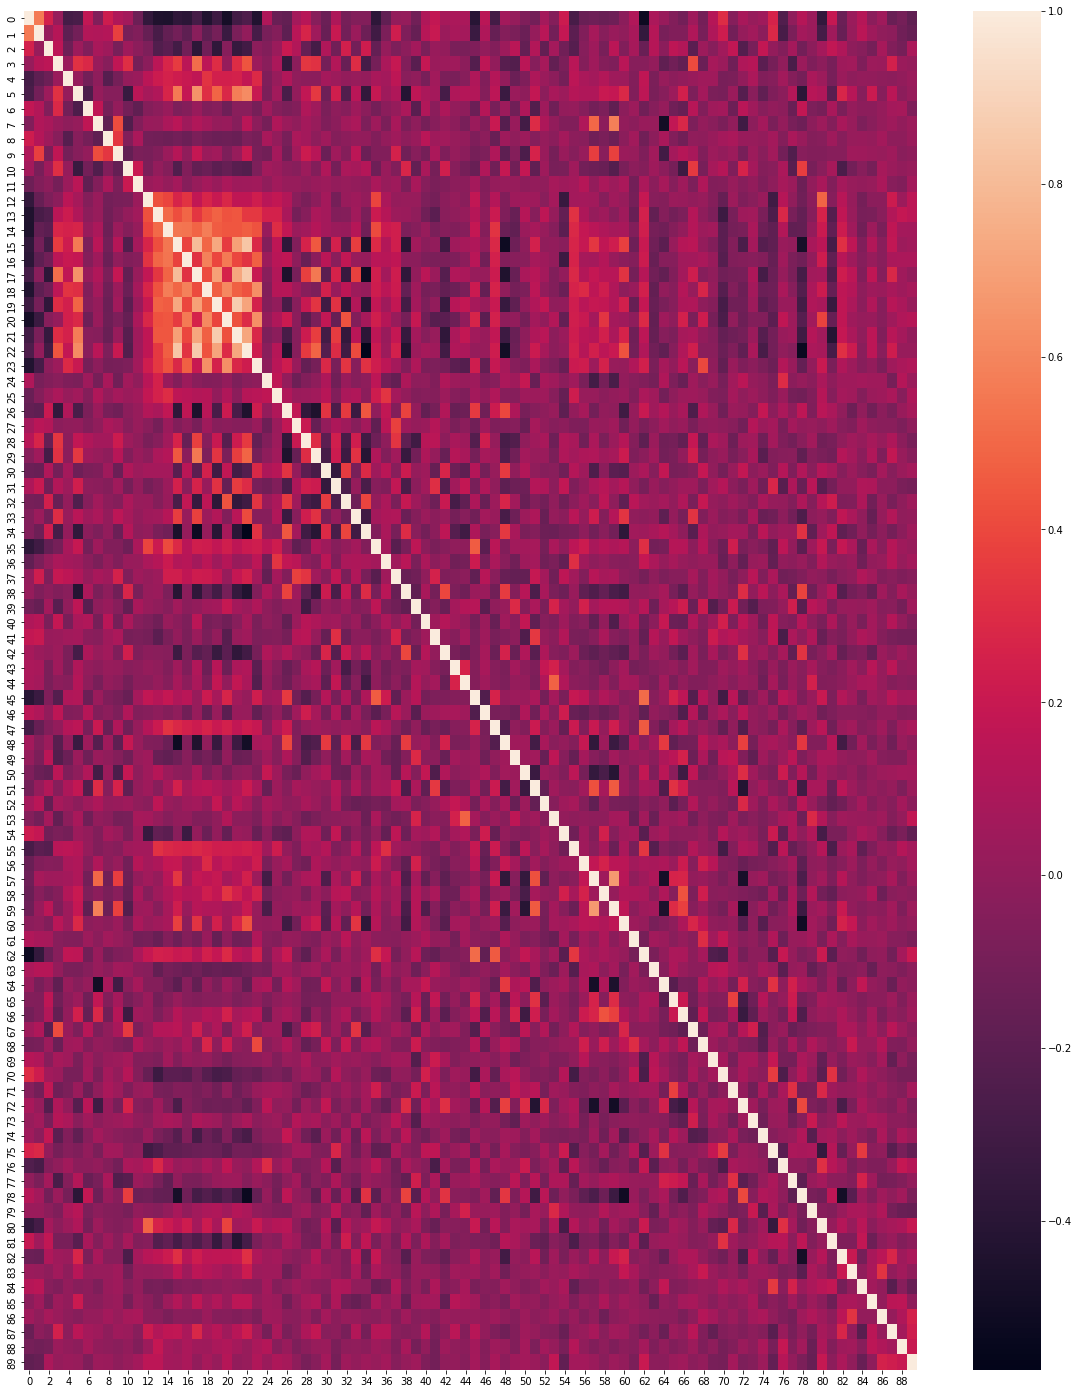

(463715, 80)


In [ ]:
plt.figure(figsize=(20, 25))

sns.heatmap(pd.DataFrame(data=X_train).corr())
plt.show()

X_train = np.delete(X_train, range(13, 23), axis=1)
X_test = np.delete(X_test, range(13, 23), axis=1)
print(X_train.shape)

Что пытались:
* Удалить взаимозависимые признаки
* Добавить $power$, $sin$, $cos$ и др. функции к значениям признаков. Не принесло никакой пользы. 

> **Имело ли вообще смысл этим заниматься, если структура модели, скорее всего, ещё совсем неокончательная?**

### Попытка поработать со значениями.

Тренируем на MSE, вдруг выбросы всё портят?    
[askpython.com](https://www.askpython.com/python/examples/detection-removal-outliers-in-python)

Проиллюстрируем изменение для какого-нибудь признака:

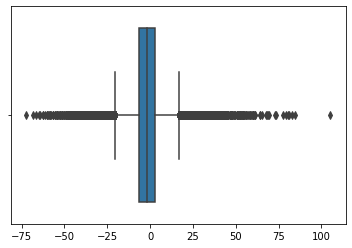

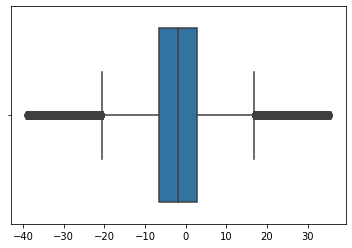

In [ ]:
sns.boxplot(x=X_train[:, 7])
plt.show()

for col_index in range(X_train.shape[1]): 
    q75,q25 = np.percentile(X_train[:, col_index], [10,90])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    X_train[:, col_index][X_train[:, col_index] > min] = np.nan
    X_train[:, col_index][X_train[:, col_index] < max] = np.nan

# Замена nan на среднее
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp_mean.fit_transform(X_train)

sns.boxplot(x=X_train[:, 7])
plt.show()

На маленьком `train` как будто помогало, на большом давало плохие результаты.

### Изменение структуры сети

Как оказалось, прорваться через значение $RMSE=9.1$ мне не давала структура сети. 
Итог: $RMSE≈8.9$

In [ ]:
# # Такой вариант:
#   batch_size = 64
#   Сеть: 90->48->24->12->6->3->1

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 856.02it/s] 


9.0612755
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 841.61it/s] 


8.966698
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 861.80it/s] 


8.936023
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 854.97it/s] 


8.90977
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 851.81it/s] 


8.89325


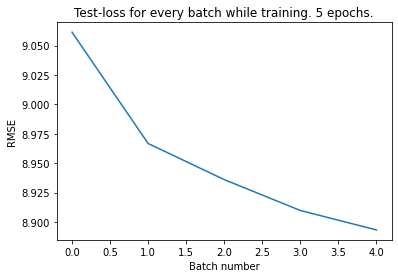

In [ ]:
# batch_size = 64
# Сеть: 90->64->32->16->8->4->1
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Впоследствии сеть стабильно имела структуру 
$90$ -> $128$ -> $256$ -> $512$ -> $256$ -> $128$ -> $64$ -> $32$ -> $16$ -> $8$ -> $4$ -> $1$

### Много-много различных попыток с графиками: 
* С доп. признаками
* Без зависимых признаков
* `weight_decay` `= 0.0001 | 0.00005 | 0.0002 ...` 
* С заменой выбросов
* Смещение `lr` на небольшое значение
* Изменение структуры сети, например, ($90$ -> $90$ -> $90$ -> $90$ -> $1$)
* `batch_size` `= 128 | 64 | 32 | 16 | 8 | 4`

Модернизация сети до 10 слоёв с числом нейронов $max=1$ помогло пробить потолок в $RMSE=8.87$

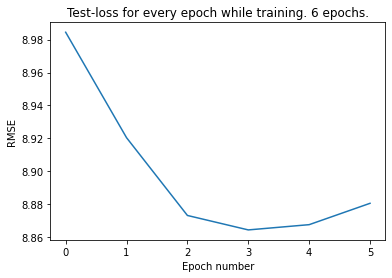

Модернизация сети до 11 нейронов с $max=1$ помогло пробить потолок в $RMSE=8.84$

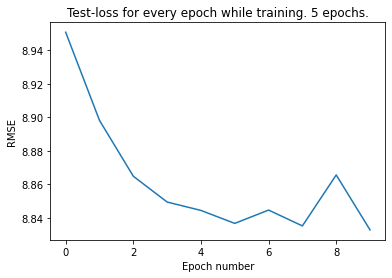

### Скучные попытки с графиками

In [ ]:
# 32, 45, Adam, 0.0023
train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1220.35it/s]

9.224406


In [ ]:
# 32, 45, Adagrad, 0.01
train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1108.36it/s]


9.332014


In [ ]:
# 8, 45, Adam, 0.0023
train(1, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 6454/6454 [00:02<00:00, 2846.52it/s]


9.2759905


Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1450.26it/s]


9.234806
Epoch = 1


100%|██████████| 1614/1614 [00:01<00:00, 1434.38it/s]


9.179613
Epoch = 2


100%|██████████| 1614/1614 [00:01<00:00, 1521.77it/s]


9.1805315
Epoch = 3


100%|██████████| 1614/1614 [00:01<00:00, 1516.56it/s]


9.148271
Epoch = 4


100%|██████████| 1614/1614 [00:01<00:00, 1511.69it/s]


9.147463


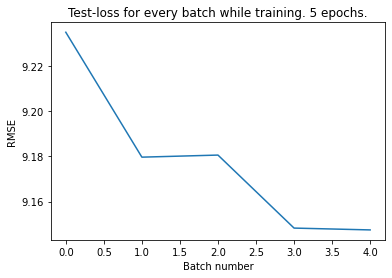

In [ ]:
# batch_size = 32, 1 скрытый слой, просто подождал
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1489.46it/s]


9.076025
Epoch = 1


100%|██████████| 1614/1614 [00:01<00:00, 1514.74it/s]


9.040942
Epoch = 2


  7%|▋         | 1062/14492 [01:49<23:09,  9.67it/s]


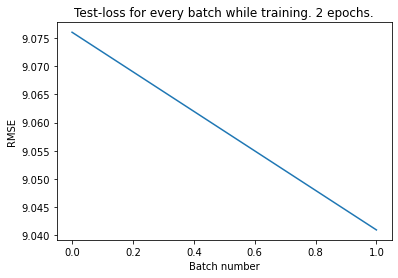

In [ ]:
# 
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1528.02it/s]


9.101781
Epoch = 1


100%|██████████| 1614/1614 [00:01<00:00, 1526.11it/s]


9.023855
Epoch = 2


100%|██████████| 1614/1614 [00:01<00:00, 1503.92it/s]


9.0088415
Epoch = 3


  1%|          | 78/14492 [00:07<24:00, 10.01it/s]


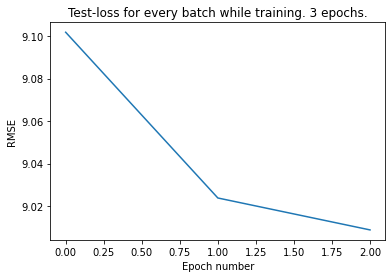

In [ ]:
# batch_size = 32, слоёв чуть больше
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

In [ ]:
# batch_size = 32, max слоёв
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1397.67it/s]


9.090267
Epoch = 1


100%|██████████| 1614/1614 [00:01<00:00, 1398.92it/s]


9.000216
Epoch = 2


100%|██████████| 1614/1614 [00:01<00:00, 1406.72it/s]


8.953946
Epoch = 3


 26%|██▋       | 3818/14492 [06:36<18:28,  9.63it/s]

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 856.02it/s] 


9.0612755
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 841.61it/s] 


8.966698
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 861.80it/s] 


8.936023
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 854.97it/s] 


8.90977
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 851.81it/s] 


8.89325


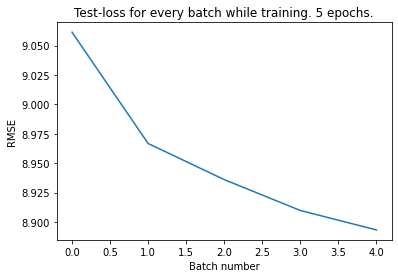

In [ ]:
# batch_size = 64, max слоёв
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

In [ ]:
# batch_size = 64, max слоёв, weight_decay, MinMaxScaler
train(5, model, optimizer, criterion, train_loader, test_loader, 'mm')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 846.43it/s] 


10.86397
Epoch = 1


 14%|█▍        | 1043/7246 [03:20<19:56,  5.18it/s]

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 880.92it/s] 


9.159009
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 868.13it/s] 


9.052924
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 812.11it/s] 


9.025672
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 815.96it/s] 


8.987195
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 849.32it/s] 


8.965


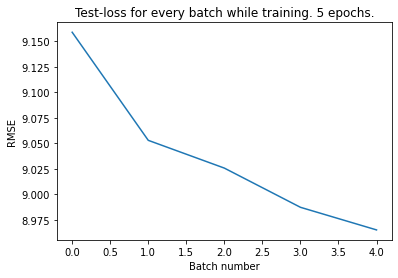

In [ ]:
# batch_size = 64, max слоёв, Без взаимосвязанных признаков
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 864.43it/s] 


9.101507
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 857.43it/s] 


8.981005
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 857.99it/s] 


8.929436
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 862.23it/s] 


8.912509
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 785.81it/s] 


8.907434


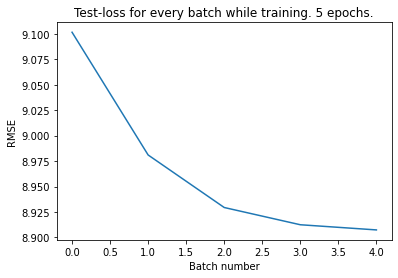

In [ ]:
# batch_size = 64, max слоёв, замена выбросов
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 837.48it/s] 


9.28733
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 851.98it/s] 


9.007349
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 818.07it/s] 


8.936947
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 843.43it/s] 


8.948528
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 825.66it/s] 


8.90576


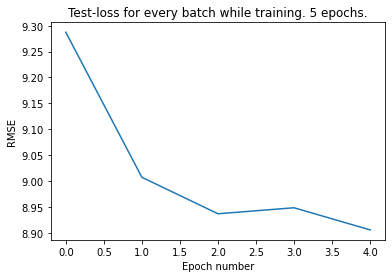

In [ ]:
# batch_size = 64, max слоёв, lr=0.0038
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 836.12it/s] 


9.069917
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 842.71it/s] 


8.98764
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 841.42it/s] 


8.996065
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 838.67it/s] 


8.936282
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 827.74it/s] 


8.941114


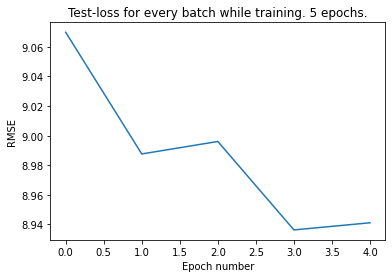

In [ ]:
# batch_size = 64, max слоёв, lr=0.0045
train(5, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 864.99it/s] 


9.099355
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 865.44it/s] 


9.00605
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 858.83it/s] 


8.961502
Epoch = 3


100%|██████████| 807/807 [00:00<00:00, 866.63it/s] 


8.957117
Epoch = 4


100%|██████████| 807/807 [00:00<00:00, 863.86it/s] 


8.93825
Epoch = 5


  9%|▉         | 676/7246 [02:10<21:04,  5.20it/s]


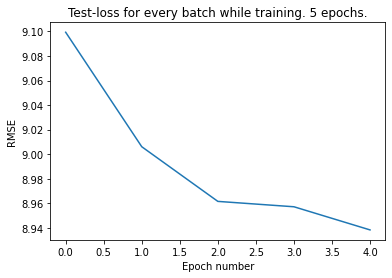

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, weight_decay=0.0001
train(7, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 804.70it/s] 


8.984468
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 776.58it/s]


8.920387
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 780.29it/s] 


8.873123
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 767.78it/s]


8.864339
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 772.48it/s]


8.867532
Epoch = 5


100%|██████████| 807/807 [00:01<00:00, 771.43it/s]


8.88051
Epoch = 6


 57%|█████▋    | 4155/7246 [13:20<09:55,  5.19it/s]


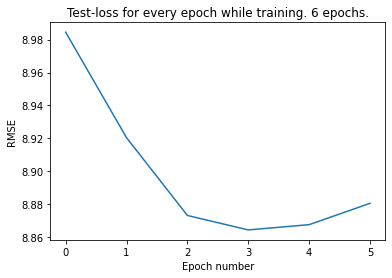

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 752.47it/s]


9.0153
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 763.17it/s]


8.929055
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 761.61it/s]


8.924771
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 757.13it/s]


8.936768
Epoch = 4


  7%|▋         | 473/7246 [01:31<21:43,  5.19it/s]


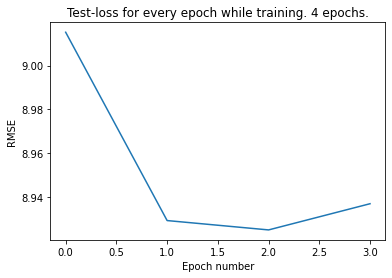

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 667.70it/s]


8.950662
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 666.95it/s]


8.898174
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 695.43it/s]


8.864928
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 700.28it/s]


8.849556
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 694.01it/s]


8.844559
Epoch = 5


100%|██████████| 807/807 [00:01<00:00, 702.98it/s]


8.836834
Epoch = 6


100%|██████████| 807/807 [00:01<00:00, 700.61it/s]


8.8447695
Epoch = 7


100%|██████████| 807/807 [00:01<00:00, 689.52it/s]


8.835336
Epoch = 8


100%|██████████| 807/807 [00:01<00:00, 697.79it/s]


8.865685
Epoch = 9


100%|██████████| 807/807 [00:01<00:00, 703.02it/s]


8.8329525


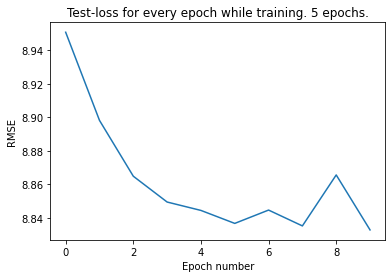

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), Замена выбросов на среднее (25,75)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 690.84it/s]


9.17906
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 690.99it/s]


9.220068
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 699.27it/s]


9.035446
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 678.13it/s]


9.044556
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 699.77it/s]


9.011664
Epoch = 5


 65%|██████▍   | 4683/7246 [15:03<08:14,  5.18it/s]

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 692.78it/s]


8.983894
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 680.43it/s]


8.942103
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 678.67it/s]


8.890735
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 684.77it/s]


8.868028
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 677.42it/s]


8.874467
Epoch = 5


100%|██████████| 807/807 [00:01<00:00, 678.70it/s]


8.86903
Epoch = 6


100%|██████████| 807/807 [00:01<00:00, 681.96it/s]


8.853642
Epoch = 7


 23%|██▎       | 1679/7246 [05:24<17:56,  5.17it/s]


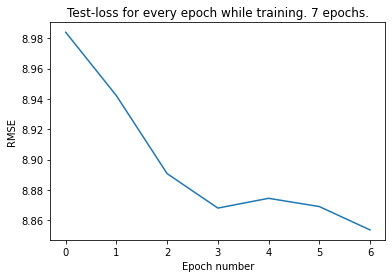

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), Замена выбросов на среднее (10,90)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), Удаление зависимых признаков
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 715.08it/s]


11.002588
Epoch = 1


 52%|█████▏    | 3791/7246 [10:51<09:54,  5.82it/s]

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 532.13it/s]


8.982697
Epoch = 1


 10%|█         | 746/7246 [04:50<42:10,  2.57it/s]


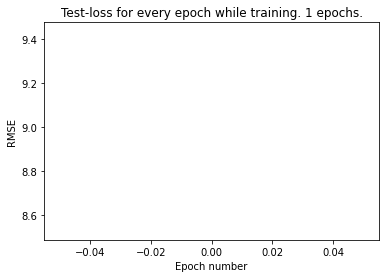

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (180 - 256 - 512 - 1024 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), 181 признак (+квадраты)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 829.60it/s] 


9.026303
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 832.47it/s] 


8.985397
Epoch = 2


100%|██████████| 807/807 [00:00<00:00, 826.67it/s] 


8.968838
Epoch = 3


  5%|▍         | 355/7246 [01:07<21:59,  5.22it/s]


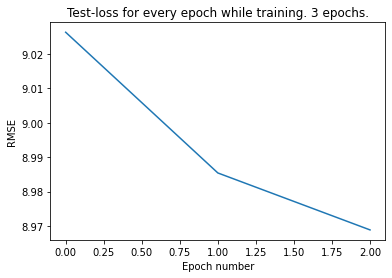

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:00<00:00, 849.01it/s] 


8.975362
Epoch = 1


100%|██████████| 807/807 [00:00<00:00, 857.08it/s] 


8.947363
Epoch = 2


  2%|▏         | 144/7246 [00:27<22:26,  5.27it/s]


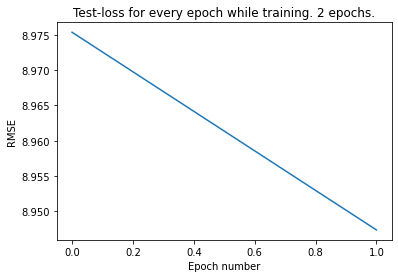

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 90 - 90 - 90 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 678.56it/s]


8.9877405
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 678.01it/s]


8.914136
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 703.88it/s]


8.882795
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 729.52it/s]


8.906809
Epoch = 4


 31%|███       | 2246/7246 [07:14<16:06,  5.17it/s]


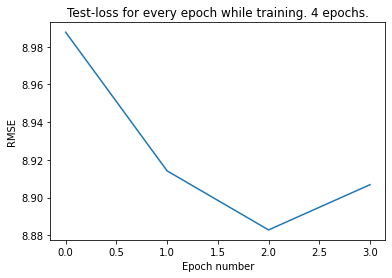

In [ ]:
# batch_size = 64, max слоёв, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 1024 - 512 - 256 - 128 - 78 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 1614/1614 [00:01<00:00, 1085.40it/s]


9.126123
Epoch = 1


 22%|██▏       | 3257/14492 [05:40<19:35,  9.56it/s]


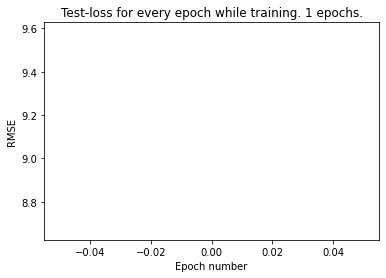

In [ ]:
# Same as previous, but batch_size=32
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 404/404 [00:00<00:00, 455.49it/s]


8.952167
Epoch = 1


100%|██████████| 404/404 [00:00<00:00, 465.32it/s]


8.913254
Epoch = 2


 17%|█▋        | 625/3623 [03:51<18:29,  2.70it/s]


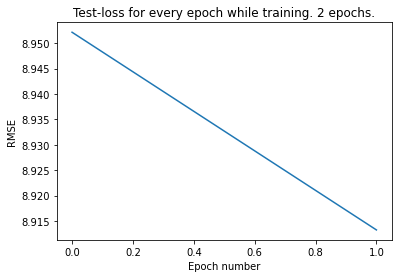

In [ ]:
# Where 8.83, but batch_size=128 
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 678.70it/s]


9.010217
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 700.77it/s]


8.943302
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 668.58it/s]


8.917277
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 688.15it/s]


8.87913
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 675.64it/s]


9.923062
Epoch = 5


100%|██████████| 807/807 [00:01<00:00, 690.50it/s]


10.97709
Epoch = 6


 16%|█▌        | 1141/7246 [03:39<19:36,  5.19it/s]


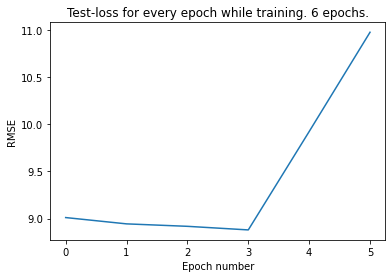

In [ ]:
# Where 8.83, lr=0.0038
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

In [ ]:
# batch_size = 64, lr=0.0023, more neurons then input (90 - 1024 - 1024 - 1024 - 1024 - 1024 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, 'std')

Epoch = 0


100%|██████████| 807/807 [00:01<00:00, 786.46it/s] 


8.962158
Epoch = 1


100%|██████████| 807/807 [00:01<00:00, 784.75it/s] 


8.91866
Epoch = 2


100%|██████████| 807/807 [00:01<00:00, 771.07it/s]


8.902853
Epoch = 3


100%|██████████| 807/807 [00:01<00:00, 764.92it/s]


8.869527
Epoch = 4


100%|██████████| 807/807 [00:01<00:00, 780.96it/s]


8.879171
Epoch = 5


100%|██████████| 807/807 [00:01<00:00, 767.26it/s]


8.855172
Epoch = 6


100%|██████████| 807/807 [00:01<00:00, 737.61it/s]


8.859777
Epoch = 7


 43%|████▎     | 3090/7246 [10:02<13:30,  5.13it/s]


Epoch = 0


100%|██████████| 7246/7246 [23:34<00:00,  5.12it/s]


8.886697097454407

Epoch = 1


100%|██████████| 7246/7246 [23:35<00:00,  5.12it/s]


8.860485712169805

Epoch = 2


 20%|█▉        | 1444/7246 [04:41<18:52,  5.12it/s]


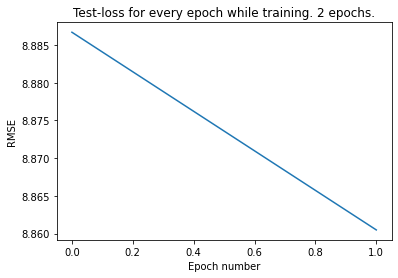

In [ ]:
# batch_size = 64, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:19<00:00,  5.18it/s]


8.950662199516943

Epoch = 1


100%|██████████| 7246/7246 [23:18<00:00,  5.18it/s]


8.898174290744366

Epoch = 2


100%|██████████| 7246/7246 [23:18<00:00,  5.18it/s]


8.864928076932449

Epoch = 3


  5%|▍         | 345/7246 [01:06<22:09,  5.19it/s]


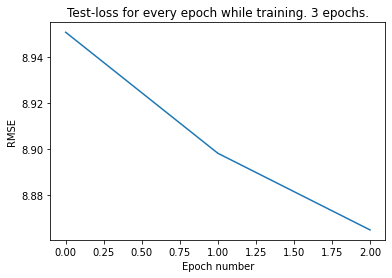

In [ ]:
# batch_size = 64, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1)
train(10, model, optimizer, criterion, train_loader, test_loader, True)

### Дополнительные средства

* `Scheduler` ─ помог добиться стабильности в достижении значений $RMSE$. [progler.ru](https://progler.ru/blog/nastroyka-skorosti-obucheniya-neyronnoy-seti-v-pytorch)
* `Dropout` ─ по описанию ужас какой классный, но у меня не получилось :(
    [towardsdatascience.com](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)
* `Dropout` с `weight_decay` ─ получше, но всё равно не очень.
* `BatchNorm1d` ─ сделал только хуже. [towardsdatascience.com](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)


Epoch = 0


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.950662199516943

Epoch = 1


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.87922772672764

Epoch = 2


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.846531173077222

Epoch = 3


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.846422385887564

Epoch = 4


  1%|          | 54/7246 [00:10<22:47,  5.26it/s]


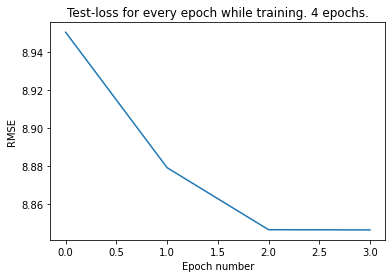

In [ ]:
# batch_size = 64, lr=0.0023, more neurons then input (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-LambdaLR(0.8) - sch every epoch
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.950662199516943

Epoch = 1


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.888991206974229

Epoch = 2


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.877669567870639

Epoch = 3


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.855741320791715

Epoch = 4


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.840116432474709

Epoch = 5


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.841748335996842

Epoch = 6


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.835631786713575

Epoch = 7


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.857666203244417

Epoch = 8


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.869776321409182

Epoch = 9


 13%|█▎        | 916/7246 [02:56<20:22,  5.18it/s]


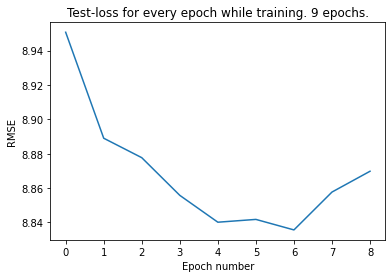

In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-LambdaLR(0.9) - sch every epoch
train(10, model, optimizer, criterion, train_loader, test_loader, True)

#### Скучные попытки с графиками

In [ ]:
# batch_size = 64, lr=0.005, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-LambdaLR(0.9) - sch every epoch
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:24<00:00,  5.16it/s]


8.98802737728556

Epoch = 1


  5%|▍         | 347/7246 [01:06<22:11,  5.18it/s]


In [ ]:
# batch_size = 64, lr=0.004, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-LambdaLR(0.9) - sch every epoch
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.978070557789334

Epoch = 1


 21%|██        | 1530/7246 [04:55<18:25,  5.17it/s]


In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-LambdaLR(0.9) - sch every epoch, weight_decay=0.00005
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


9.00481705283068

Epoch = 1


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.916553144626505

Epoch = 2


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.907577260836273

Epoch = 3


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.89176696865148

Epoch = 4


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.87775978229061

Epoch = 5


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.871170773290169

Epoch = 6


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.866205639563226

Epoch = 7


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.862707209179552

Epoch = 8


100%|██████████| 7246/7246 [23:20<00:00,  5.17it/s]


8.858261797768039

Epoch = 9


 11%|█▏        | 827/7246 [02:39<20:41,  5.17it/s]

In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-ExponentialLR(0.8) - sch every epoch, weight_decay=0.00001, dropout
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [23:22<00:00,  5.17it/s]


9.0224824910288

Epoch = 1


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.9765235818668

Epoch = 2


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.89920235108271

Epoch = 3


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.874231008836029

Epoch = 4


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.85989695454736

Epoch = 5


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.84545027227103

Epoch = 6


 97%|█████████▋| 7050/7246 [22:43<00:37,  5.17it/s]


Epoch = 0


100%|██████████| 7246/7246 [23:25<00:00,  5.15it/s]


9.07532796682991

Epoch = 1


100%|██████████| 7246/7246 [23:22<00:00,  5.17it/s]


8.956797397015192

Epoch = 2


100%|██████████| 7246/7246 [23:22<00:00,  5.17it/s]


8.942647792504948

Epoch = 3


100%|██████████| 7246/7246 [23:22<00:00,  5.17it/s]


8.877142934874769

Epoch = 4


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.865094888218087

Epoch = 5


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.877941342185844

Epoch = 6


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.865994697089688

Epoch = 7


100%|██████████| 7246/7246 [23:21<00:00,  5.17it/s]


8.873494881634404

Epoch = 8


  1%|          | 54/7246 [00:10<22:52,  5.24it/s]


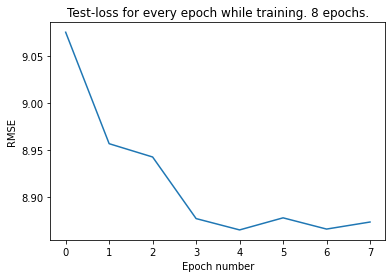

In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-ExponentialLR(0.8) - sch every epoch, weight_decay=0.00001, dropout
train(10, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [24:58<00:00,  4.84it/s]


9.00481705283068

Epoch = 1


100%|██████████| 7246/7246 [24:58<00:00,  4.83it/s]


8.916150330931295

Epoch = 2


100%|██████████| 7246/7246 [24:57<00:00,  4.84it/s]


8.884930938321464

Epoch = 3


100%|██████████| 7246/7246 [24:56<00:00,  4.84it/s]


8.874944145364733

Epoch = 4


 18%|█▊        | 1300/7246 [04:29<20:33,  4.82it/s]


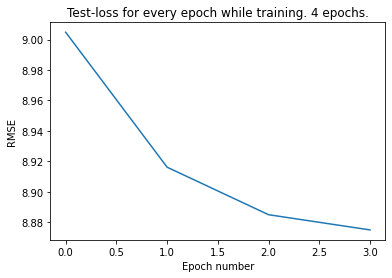

In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-Exponential - sch every epoch, weight_decay=0.00005
train(15, model, optimizer, criterion, train_loader, test_loader, True)

In [ ]:
np.min(val_res)

8.845802695719874

In [ ]:
# batch_size = 64, lr=0.0023, (90 - 128 - 256 - 512 - 256 - 128 - 64 - 32 - 16 - 8 - 4 - 1), scheduler-Exponential(0.08) - sch every epoch, weight_decay=0.00005
train(15, model, optimizer, criterion, train_loader, test_loader, True)


Epoch = 0


100%|██████████| 7246/7246 [30:49<00:00,  3.92it/s]


9.00481705283068

Epoch = 1


100%|██████████| 7246/7246 [30:49<00:00,  3.92it/s]


8.916150330931295

Epoch = 2


100%|██████████| 7246/7246 [30:48<00:00,  3.92it/s]


8.884930938321464

Epoch = 3


100%|██████████| 7246/7246 [30:49<00:00,  3.92it/s]


8.874944145364733

Epoch = 4


100%|██████████| 7246/7246 [30:51<00:00,  3.91it/s]


8.866088206025895

Epoch = 5


100%|██████████| 7246/7246 [30:50<00:00,  3.92it/s]


8.87269362726847

Epoch = 6


 76%|███████▌  | 5501/7246 [23:22<18:16,  1.59it/s]

In [ ]:
res = test(model, criterion, test_loader_for_val_test)

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


In [ ]:
res

tensor([[-0.2274],
        [ 0.7859],
        [ 0.3323],
        ...,
        [ 0.1164],
        [ 0.3068],
        [ 0.4819]], device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
res * STD + MEAN

tensor([[1995.8981],
        [2006.9835],
        [2002.0211],
        ...,
        [1999.6599],
        [2001.7421],
        [2003.6577]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
mean_squared_error((y_test * STD + MEAN).cpu().detach(), (res * STD + MEAN).cpu().detach(), squared=False)

9.224406

In [ ]:
y_test * STD + MEAN

# Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

## Здравствуйте! 

>_**Примечания:**_

> 1. *Поскольку решения эволюционировали (функции изменили свою структуру), большинство из экспериментальных запусков выше не поддерживаются.* 
2. *В процессe решения задачи использовалось несколько `.ipynb` ноутбуков, а также консольный интерфейс для использования ресурсов ПК.*

### Эксперименты

#### **Эксперимент 1.** (`StepLR`)

Эксперимент проводился как на ПК (исследование), так и в Colab (демо). 

К сожалению, не удалось довести до $RMSE<=8.779...$, т.к. Colab решил прекратить сессию 😞

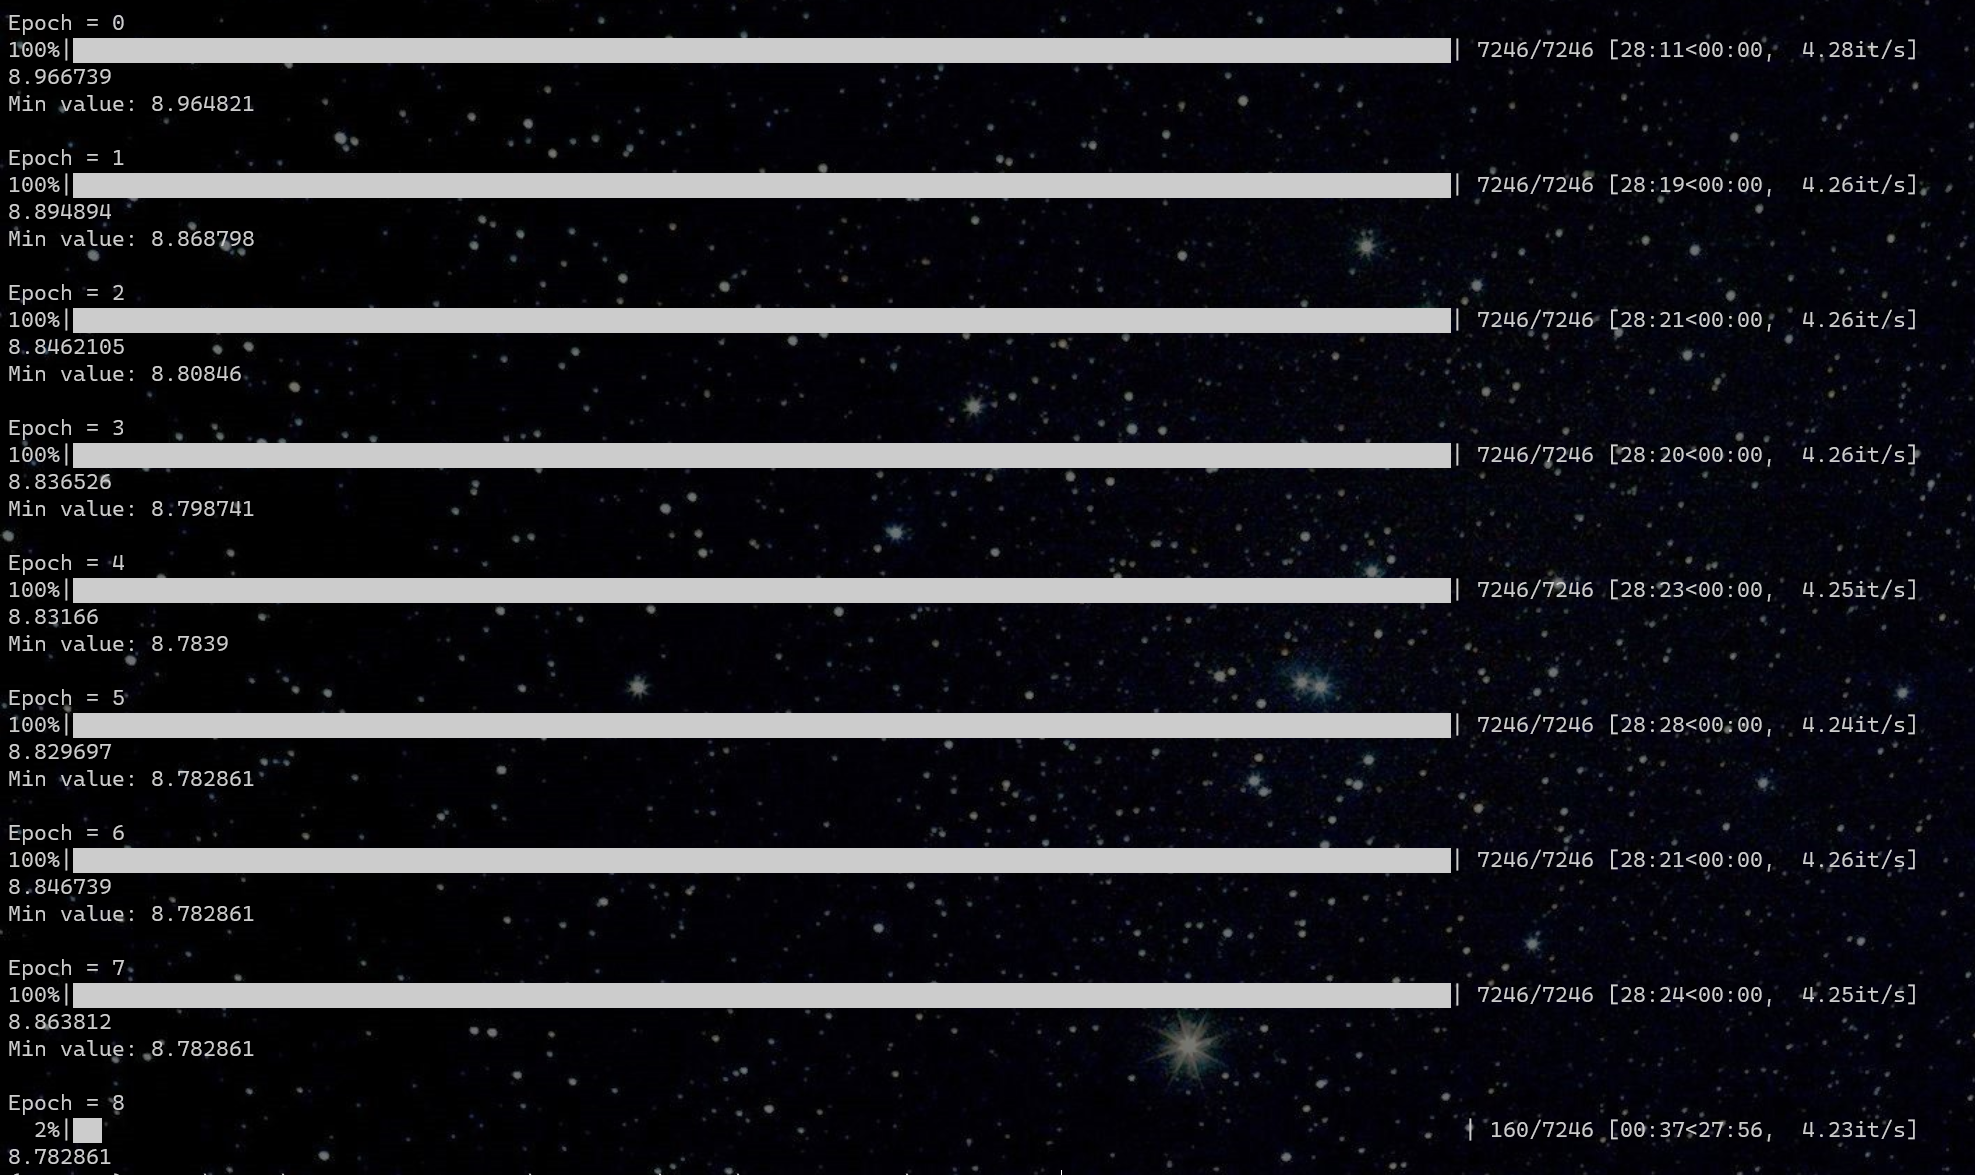


Epoch = 0


100%|██████████| 7246/7246 [30:52<00:00,  3.91it/s]


Epoch - RMSE: 8.950662199516943
Min value: 8.942817811598527

Epoch = 1


100%|██████████| 7246/7246 [30:56<00:00,  3.90it/s]


Epoch - RMSE: 8.898174290744366
Min value: 8.87803826145975

Epoch = 2


100%|██████████| 7246/7246 [30:51<00:00,  3.91it/s]


Epoch - RMSE: 8.851578424983524
Min value: 8.815511153587789

Epoch = 3


  6%|▌         | 440/7246 [01:52<29:01,  3.91it/s]


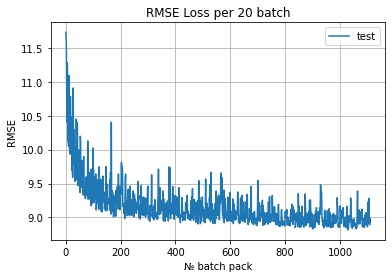

In [ ]:
val_res = []

set_random_seed(SEED)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
).to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0023)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
criterion = nn.MSELoss()

val_res, batches, best_model = train(10, model, optimizer, criterion, scheduler, train_loader, test_loader, graphics=True, scaler=scaler, early_stopping=True, new_session=True)

Приостановили обучение для построения графика.
Продолжим...

In [ ]:
val_res, batches, best_model = train(8, model, optimizer, criterion, scheduler, train_loader, test_loader, graphics=True, scaler=scaler, early_stopping=True, new_session=False, old_data=(val_res, rmse_s, batches, n_batch, current_min, best_model, current_mins))


Epoch = 0


100%|██████████| 7246/7246 [30:47<00:00,  3.92it/s]


Epoch - RMSE: 8.846129077900576
Min value: 8.7974543625473

Epoch = 1


100%|██████████| 7246/7246 [30:49<00:00,  3.92it/s]


Epoch - RMSE: 8.836408805324638
Min value: 8.78893610057369

Epoch = 2


100%|██████████| 7246/7246 [30:49<00:00,  3.92it/s]


Epoch - RMSE: 8.842147984837842
Min value: 8.779979700048763

Epoch = 3


 43%|████▎     | 3088/7246 [13:10<17:02,  4.07it/s]

Итак, результат: $RMSE=8.78$

#### **Эксперимент 2.** (`ExponentialLR`)

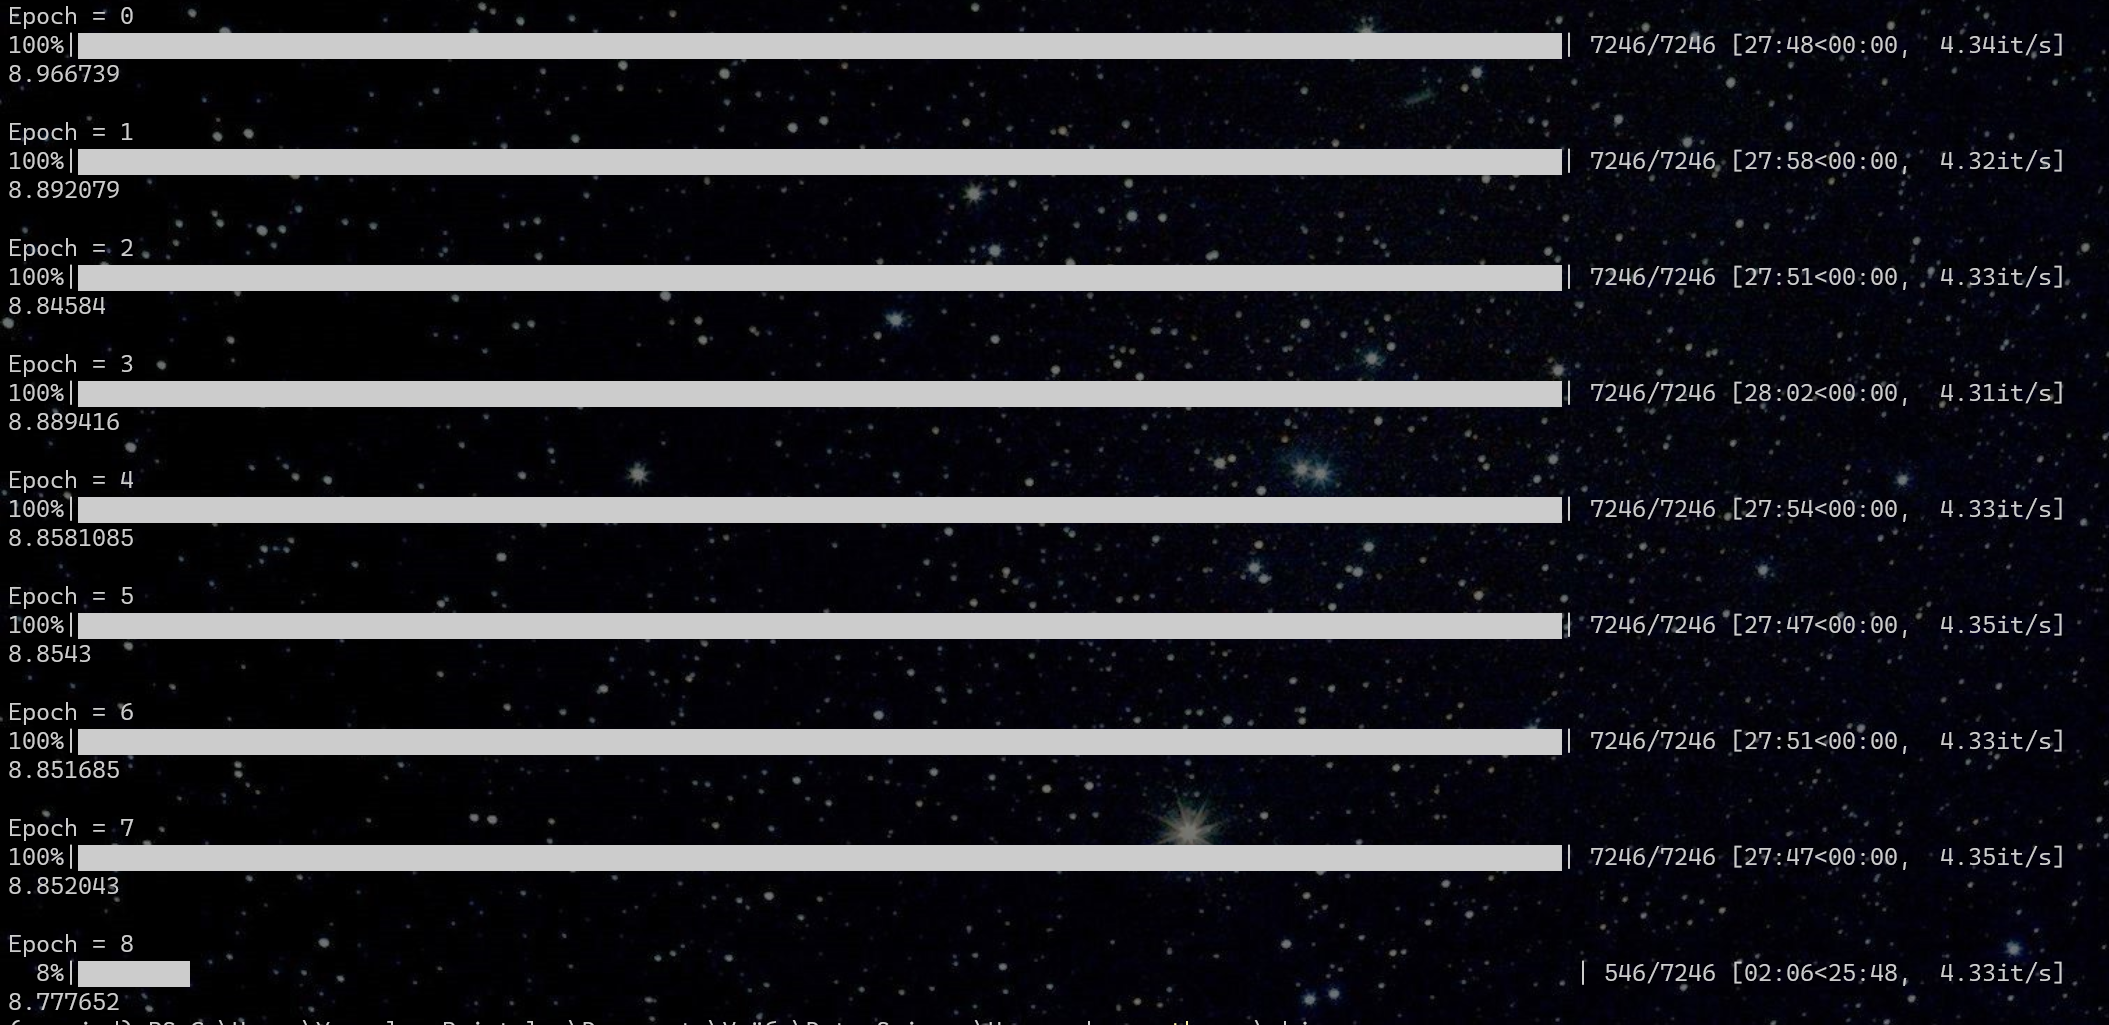


Epoch = 0


100%|██████████| 7246/7246 [30:58<00:00,  3.90it/s]


Epoch - RMSE: 8.950662199516943
Min value: 8.942817811598527

Epoch = 1


100%|██████████| 7246/7246 [31:00<00:00,  3.89it/s]


Epoch - RMSE: 8.87922772672764
Min value: 8.860391325876712

Epoch = 2


100%|██████████| 7246/7246 [30:54<00:00,  3.91it/s]


Epoch - RMSE: 8.846531173077222
Min value: 8.813148096834313

Epoch = 3


100%|██████████| 7246/7246 [30:51<00:00,  3.91it/s]


Epoch - RMSE: 8.846422385887564
Min value: 8.785827460823299

Epoch = 4


100%|██████████| 7246/7246 [30:56<00:00,  3.90it/s]


Epoch - RMSE: 8.844649589193054
Min value: 8.766184672571187

Epoch = 5


100%|██████████| 7246/7246 [30:42<00:00,  3.93it/s]


Learning was stopped because the best result isn't changing for 3 epochs


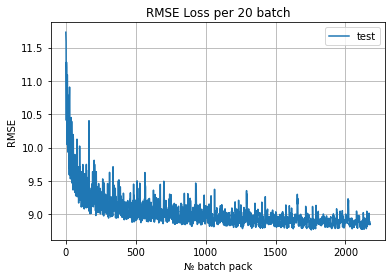

In [ ]:
set_random_seed(SEED)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
).to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0023)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.MSELoss()

val_res, batches, best_model = train(15, model, optimizer, criterion, scheduler, train_loader, test_loader, graphics=True, scaler=scaler, early_stopping=True, new_session=True)

В итоге *лучший результат* $RMSE=8.766$.

#### **Эксперимент 3.** (`Dropout`, `weight_decay`, `ExponentialLR`)

Работа с моделью производилась локально, ниже приведён текст консольного вывода. Значения `loss`'a на тесте после каждого 20-го батча обучения сохранялись в текстовый файл.


```
(env_iad) PS C:\Users\Yaroslav Pristalov\Documents\Учёба\Data Science\Homeworks> python .\homework_1_basic_version.py
device = 'cuda'
(463715, 90)
(463715,)
Epoch = 0
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:00<00:00,  4.16it/s]
9.021027
Min value: 9.004222

Epoch = 1
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:03<00:00,  4.16it/s]
8.937814
Min value: 8.921854

Epoch = 2
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [28:54<00:00,  4.18it/s]
8.930244
Min value: 8.869554

Epoch = 3
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:10<00:00,  4.14it/s]
8.887051
Min value: 8.8552265

Epoch = 4
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [28:59<00:00,  4.16it/s]
8.890135
Min value: 8.839451

Epoch = 5
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:17<00:00,  4.12it/s]
8.863334
Min value: 8.827731

Epoch = 6
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:09<00:00,  4.14it/s]
8.870345
Min value: 8.8132

Epoch = 7
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:16<00:00,  4.13it/s]
8.873814
Min value: 8.807486

Epoch = 8
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [29:02<00:00,  4.16it/s]
8.857448
Min value: 8.806468

Epoch = 9
100%|████████████████████████████████████████████████████████████████████████████████| 7246/7246 [28:59<00:00,  4.17it/s]
8.8752985
Min value: 8.80492
```
8.80492

11.731038 11.647462 11.552408 11.154522 11.74736 11.286557 11.301289 11.140572 10.956279 10.538759 11.037767 10.691652 10.415664 11.022269 10.284821 10.711958 10.770519 10.934134 10.350354 10.371136 11.040913 10.556415 12.474264 10.825534 10.363646 10.029816 10.34195 10.516154 10.333921 10.162212 10.659234 10.181967 10.231147 9.857559 9.812583 10.152232 9.790369 9.68066 10.3141985 9.805566 9.89209 9.655435 10.133516 9.897513 10.086471 9.746488 9.849124 9.819805 9.755575 9.878827 9.712387 9.883373 9.661637 10.05133 10.027906 9.616151 9.902378 9.7529335 9.559607 9.575013 9.710673 9.936882 9.622139 9.525102 9.496795 9.7437725 9.567992 9.425984 9.421962 9.65339 9.513782 9.320246 9.351079 9.525789 9.703098 9.716037 9.428442 9.496231 9.60607 9.434815 9.957396 9.677873 9.403112 9.394341 9.6014 9.478097 9.475244 9.370624 9.360837 9.353094 9.37189 9.407106 9.305908 9.794517 9.5962105 9.446666 9.533728 9.503775 9.295684 10.202229 9.652317 9.757697 9.563441 9.230094 9.658914 9.642591 9.54171 9.39

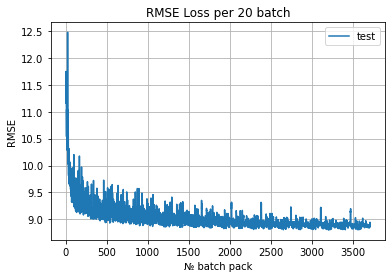

In [ ]:
val_res = list(map(float, input().split())) # Значения loss, сохранённые в файл на ПК.
print("Best RMSE:", np.min(val_res))
assert np.isclose(8.80492, np.min(val_res))

plt.plot(range(len(val_res)), val_res, label="test")
plt.title("RMSE Loss per 20 batch")
plt.xlabel("№ batch pack")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()

In [ ]:
set_random_seed(SEED)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
).to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0023, weight_decay=0.00002)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.MSELoss()

val_res, batches, best_model = train(10, model, optimizer, criterion, scheduler, train_loader, test_loader, graphics=True, scaler=scaler, early_stopping=True, new_session=True)

### Вопросы и выводы: 

Так как цель работы не оценка, а знания, хотелось бы выяснить, как поменьше страдать) Да, хорошо, будем использовать `pytorch_lightning`, но как он поможет в подборе ЭТОГО ОГРОМНОГО КОЛИЧЕСТВА ГИПЕРПАРАМЕТРОВ? Нельзя провести прямой зависимости результата от тестов гиперпараметров на несовершенной модели. Да и сами гиперпараметры, чаще всего, влияют друг на друга (настройка одного портит настройку другого), а все комбинации уж точно не проверишь.

Почему получилось так, что `learning_rate`, настроенный на не очень хорошей модели актуален для модели получше? Как подбирать вероятности `Dropout`'а? 

Всё, про что я читал (`weight_decay`, `Dropout`, `BatchNorm1d`, `lr_scheduler` и т.д.), по словам рассказчиков, просто потрясающе влияет на модель. Пробуешь ─ не получается. 
 **И так все DL'щики работают?**

А ведь люди на 8.60, вроде бы, решают! Может быть, надо книги по ML почитать? Что мне делать (если я хочу в эту профессию), чтобы не так больно было?

Ну и общий **вопрос**: имеет ли смысл пытаться лезть в тонкие вещи вроде дропаута на ранних стадиях создания модели? Потому что я много времени потратил на настройку таких вещей, а потом оказалось, что проблема была в структуре модели. Это всё ОПЫТ ОПЫТ ОПЫТ, но, может быть, со стороны Вашего опыта есть какие-то советы. (Если они могут быть вообще ввиду абсолютной разнообразности данных)

> **Как можно улучшить модель?!** Просто хотелось бы осознать хорошую версию решения...

**Проблемы:**

* Наличие видеокарты и наконец-то полученного мной системного доступа к CUDA-ядрам очень сильно помогло поменьше переживать из-за того, что неподходящий предательски отвалится Colab.

* Тяжело обеспечивать качество кода. В обычном мире вроде бы для этого есть Unit-тесты, а тут и протестировать ничего толком нельзя, пока модель не пообучается.

* Достаточно длинное время обучения.
---